In [1]:
import pandas as pd
import numpy as np
import time

# Data visualization and manipulation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from pprint import pprint

# Natural language processing and modeling
import nltk.sentiment
import nltk
import re
from scipy.stats import f_oneway, stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import ToktokTokenizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
# SQL credentials and data acquisition
# import env as e
# import acquire as a
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
from bs4 import BeautifulSoup

# GitHub API credentials
# from env import github_token, github_username

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Miatta wrangle files

In [2]:
def tokenize(text):
    """
    Tokenizes the words in the input string.
    """
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens

def clean(text: str) -> list: 
    """
    Cleans up the input text data.
    """
    text = (text.encode('ascii', 'ignore')
                .decode('utf-8', 'ignore')
                .lower())
    
    words = re.sub(r'[^\w\s]', ' ', text).split()
    
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = set(nltk.corpus.stopwords.words('english'))
    
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

def nlp_wrangle():
    """
    Performs data wrangling for natural language processing (NLP) tasks.
    Returns a processed DataFrame for NLP analysis.
    """
    # Load data from JSON file
    df = pd.read_json('data2.json')
    
    # Tokenize and clean contents
    df['clean_contents'] = df.readme_contents.apply(tokenize).apply(' '.join)
    df['clean_contents'] = df.clean_contents.apply(clean).apply(' '.join)
    
     # Words to remove
    words_to_remove = ['http', 'com', '124', 'www','github', 'top', 'go','107', '0','1','2','3','4', '5', '6', '7', '8','9', 'md','p', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'em', 'abbr', 'q','ins', 'del', 'dfn', 'kbd', 'pre', 'samp', 'var', 'br', 'div', 'a', 'img', 'param', 'ul','ol', 'li', 'dl', 'dt', 'dd']

    # Remove specific words from clean_contents
    for word in words_to_remove:
        df['clean_contents'] = df['clean_contents'].str.replace(word, '')

    # Add message_length and word_count columns
    df['message_length'] = df['clean_contents'].str.len()
    df['word_count'] = df.clean_contents.apply(clean).apply(len)

    # Keep only top languages and assign others to 'Other'
    languages_to_keep = ['JavaScript', 'Python', 'Java', 'TypeScript', 'HTML']
    df['language'] = np.where(df['language'].isin(languages_to_keep), df['language'], 'Other')

    # Filter DataFrame based on conditions
    df = df.loc[(df['word_count'] <= 10000) & (df['message_length'] <= 60000)]

    return df

#Creates a list called intersect that gives all the actual dictionary words in the corpus derived from the intersection of the corpus with the native dictionary of words in the macbook
def intersection_list():
    #Creates a list of "words" from the corpus of the readmes
    words_df = nlp_wrangle()
    readme_words_list = words_df.clean_contents.to_list()
    readme_words_list
    
    #splits the readme article into a list of words and appends to the readme_words_list
    readme_words = []
    for list in readme_words_list:
        split_list = list.split()
        readme_words.append(split_list)
    #Creates a final words_list for the whole corpus
    words_list = []
    for _ in readme_words:
        for el in _:
            words_list.append(el)
    #Pulls the dictionary words from the computer dictionary "MAC" and finds the intersection between this list and the Readme Corpus to find all the actual words in the corpus
    dictionary_words = pd.read_csv('/usr/share/dict/words', header=None)
    dictionary_words = dictionary_words.drop(index=[122337,122338])
    dictionary_words = dictionary_words.squeeze()
    intersect = set(words_list) & set(dictionary_words)
    intersect = sorted(intersect)
    return intersect

#Creates an extra clean column that rmoves all the non-words from the individual README files
def extra_clean_column(words_df):
    extra_clean_article = []
    #Loops through each row in the clean_contents column and appends to the extra_clean_article list above as a list of lists
    for i in words_df.index:
        article_words = words_df.clean_contents[i].split()
        extra_clean = set(intersect) & set(article_words)
        extra_clean = sorted(extra_clean)
        extra_clean = ' '.join(extra_clean)
        extra_clean_article.append(extra_clean)
    #Creates a new column from this list of lists which is appendeded to the words_df and returned as such
    words_df = words_df.assign(extra_clean_contents = extra_clean_article) 
    return words_df

In [3]:
words_df = nlp_wrangle()
intersect = intersection_list()
words_df = extra_clean_column(words_df)
words_df

,repo,language,readme_contents,clean_contents,message_length,word_count,extra_clean_contents
0,TheAlgorithms/Python,Python,"<div align=""center"">\n<!-- Title: -->\n <a hr...",gn center title href thelrithms src rw u...,1585,257,b better blob blue build center code contribut...
1,apache/flink,Java,# Apache Flink\n\nApache Flink is an open sour...,che fnk che fnk oen source strem rocessing frm...,2722,454,bug build building built che check clone code ...
2,forezp/SpringCloudLearning,Java,>转载请标明出处： \n> http://blog.csdn.net/forezp/arti...,blog csdn net forez rticle detil blog csdn ...,4370,617,boot boots bus center cloud cor discovery f fe...
3,learn-co-students/python-dictionaries-readme-d...,Other,\n# Dictionaries \n\n### Introduction\n\nAfter...,dictionry introduction introducing working st ...,5385,828,bee beginning bit built ce continue correct co...
4,angular/angular-phonecat,JavaScript,# AngularJS Phone Catalog Tutorial Application...,ngrjs hone ctlog tutoril ction overview ction ...,6259,1028,b best binding bine building cent check checko...
...,...,...,...,...,...,...,...
109,lin-xin/vue-manage-system,Other,"{""payload"":{""allShortcutsEnabled"":false,""fileT...",ylod llshortcutsenbled flse filetree it nme t...,15727,2730,best blob body build c cense checked clone cod...
110,Significant-Gravitas/Auto-GPT,Python,"{""payload"":{""allShortcutsEnabled"":false,""fileT...",ylod llshortcutsenbled flse filetree it nme de...,30234,4748,b bed blob block blue body border bottom busin...
112,namndwebdev/tang-crush,JavaScript,"{""payload"":{""allShortcutsEnabled"":false,""fileT...",ylod llshortcutsenbled flse filetree it nme cs...,5387,830,bit blob body c cho code content coy crush d d...
113,learn-co-students/javascript-arrays-lab-bootca...,JavaScript,"{""payload"":{""allShortcutsEnabled"":false,""fileT...",ylod llshortcutsenbled flse filetree it nme te...,8871,1248,beginning bit bite blob body bug butter cense ...


### Baseline

In [4]:
words_df.language.value_counts()

Other         42
JavaScript    26
Python        12
Java          11
HTML           6
TypeScript     3
Name: language, dtype: int64

In [5]:
Baseline = words_df.language.value_counts()[0] / len(words_df)
Baseline

0.42

### Use functions from the miatta model py file and put into a model.py

In [6]:
def split_data(df, variable):
    """
    Splits the data into train, validate, and test DataFrames.

    Args:
    df (pandas.DataFrame): Input DataFrame.
    variable (str): Target variable name.

    Returns:
    train, validate, test DataFrames.

    """
    train_validate, test = train_test_split(df, test_size=0.20, random_state=123, stratify=df[variable])
    train, validate = train_test_split(train_validate, test_size=0.25, random_state=123, stratify=train_validate[variable])
    return train, validate, test


def prepare_for_modeling(train, validate, test):
    """
    Prepare the data for modeling by creating feature and target variables.

    Args:
    train (pandas.DataFrame): Training data.
    validate (pandas.DataFrame): Validation data.
    test (pandas.DataFrame): Test data.

    Returns:
    X_bow, X_validate_bow, X_test_bow, y_train, y_validate, y_test
    """
    # Create feature and target variables
    X_train = train.extra_clean_contents
    X_validate = validate.extra_clean_contents
    X_test = test.extra_clean_contents
    y_train = train.language
    y_validate = validate.language
    y_test = test.language

    # Create bag-of-words representations
    cv = CountVectorizer()
    X_bow = cv.fit_transform(X_train)
    X_validate_bow = cv.transform(X_validate)
    X_test_bow = cv.transform(X_test)
    
    feature_names = cv.get_feature_names_out()
    
    return X_bow, X_validate_bow, X_test_bow, y_train, y_validate, y_test, feature_names

def decision_tree(X_bow, X_validate_bow, y_train, y_validate):
    """
    Train a decision tree classifier and evaluate performance.

    Args:
    X_bow, X_validate_bow: Bag-of-words representations.
    y_train, y_validate: Target variables.

    Returns:
    scores_df (pandas.DataFrame): Accuracy scores for different max_depth values.
    """
    # Train and evaluate decision tree classifier
    scores_all = []
    for x in range(1, 20):
        tree = DecisionTreeClassifier(max_depth=x, random_state=123)
        tree.fit(X_bow, y_train)
        train_acc = tree.score(X_bow, y_train)
        val_acc = tree.score(X_validate_bow, y_validate)
        score_diff = train_acc - val_acc
        scores_all.append([x, train_acc, val_acc, score_diff])

    scores_df = pd.DataFrame(scores_all, columns=['max_depth', 'train_acc', 'val_acc', 'score_diff'])

    # Visualize results
    sns.set_style('whitegrid')
    plt.plot(scores_df['max_depth'], scores_df['train_acc'], label='Train score')
    plt.plot(scores_df['max_depth'], scores_df['val_acc'], label='Validation score')
    plt.fill_between(scores_df['max_depth'], scores_df['train_acc'], scores_df['val_acc'], alpha=0.2, color='gray')
    plt.xlabel('Max depth')
    plt.ylabel('Accuracy')
    plt.title('Decision Tree Accuracy vs Max Depth')
    plt.legend()
    plt.show()

    return scores_df

def random_forest_scores(X_bow, y_train, X_validate_bow, y_validate):
    """
    Train and evaluate a random forest classifier with different hyperparameters.

    Args:
    X_bow, X_validate_bow: Bag-of-words representations.
    y_train, y_validate: Target variables.

    Returns:
    df (pandas.DataFrame): Model performance summary.
    """
    # Define hyperparameters
    train_scores = []
    validate_scores = []
    min_samples_leaf_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    max_depth_values = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

    # Train and evaluate random forest classifier
    for min_samples_leaf, max_depth in zip(min_samples_leaf_values, max_depth_values):
        rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, max_depth=max_depth, random_state=123)
        rf.fit(X_bow, y_train)
        train_score = rf.score(X_bow, y_train)
        validate_score = rf.score(X_validate_bow, y_validate)
        train_scores.append(train_score)
        validate_scores.append(validate_score)

    # Calculate differences between train and validation scores
    diff_scores = [train_score - validate_score for train_score, validate_score in zip(train_scores, validate_scores)]
    
    # Create summary DataFrame
    
    df = pd.DataFrame({
        'min_samples_leaf': min_samples_leaf_values,
        'max_depth': max_depth_values,
        'train_score': train_scores,
        'validate_score': validate_scores,
        'score_difference': diff_scores
    })
    
    # Visualize results
    sns.set_style('whitegrid')
    plt.plot(df['min_samples_leaf'], df['train_score'], label='Train score')
    plt.plot(df['min_samples_leaf'], df['validate_score'], label='Validation score')
#     plt.fill_between(df['train_score'], df['validate_score'], alpha=0.2, color='gray')
    plt.xlabel('Min Samples Leaf')
    plt.ylabel('Accuracy')
    plt.title('Decision Tree Accuracy vs Max Depth')
    plt.legend()
    plt.show()

    return df

def k_nearest(X_bow, y_train, X_validate_bow, y_validate):
    """
    Trains and evaluates KNN models for different values of k and plots the results.

    Parameters:
    -----------
    X_bow: array-like, shape (n_samples, n_features)
        Bag-of-words representations of training samples.
    y_train: array-like, shape (n_samples,)
        Target values for the training samples.
    X_validate_bow: array-like, shape (n_samples, n_features)
        Bag-of-words representations of validation samples.
    y_validate: array-like, shape (n_samples,)
        Target values for the validation samples.

    Returns:
    --------
    results: pandas DataFrame
        Contains the train and validation accuracy for each value of k.
    """
    # KNN model evaluation for different values of k
    metrics = []
    train_score = []
    validate_score = []
    for k in range(1, 21):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_bow, y_train)
        train_score.append(knn.score(X_bow, y_train))
        validate_score.append(knn.score(X_validate_bow, y_validate))
        diff_score = train_score[-1] - validate_score[-1]
        metrics.append({'k': k, 'train_score': train_score[-1], 'validate_score': validate_score[-1], 'diff_score': diff_score})

    baseline_accuracy = (y_train == 6).mean()

    results = pd.DataFrame.from_records(metrics)

    # Visualize results
    sns.set_style('whitegrid')
    plt.plot(results['k'], results['train_score'], label='Train score')
    plt.plot(results['k'], results['validate_score'], label='Validation score')
#     plt.fill_between(df['train_score'], df['validate_score'], alpha=0.2, color='gray')
    plt.xlabel('K Neighbors')
    plt.ylabel('Accuracy')
    plt.title('KNN')
    plt.legend()
    plt.show()

    return results

#Function that gives the classification matrix for the model that performed the best in the train and validate phase
def best_model_classification_matrix(X_bow, y_train, X_validate_bow, y_validate):
    scores_all = []
    tree = DecisionTreeClassifier(max_depth=1, random_state=123)
    tree.fit(X_bow, y_train)
    train_acc = tree.score(X_bow, y_train)
    val_acc = tree.score(X_validate_bow, y_validate)
    score_diff = train_acc - val_acc
    scores_all.append([train_acc, val_acc, score_diff])

    y_predictions = tree.predict(X_bow)
    
    # Produce report on actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of 1 train")
    print(pd.DataFrame(report))
    print()
    
    y_validate_predictions = tree.predict(X_validate_bow)
    
    # Produce report on actual y values and this model's predicted y values
    report = classification_report(y_validate, y_validate_predictions, output_dict=True)
    print(f"Tree with max depth of 1 validate")
    print(pd.DataFrame(report))
    print()
    
#Final Test function
def final_test(X_bow, y_train, X_validate_bow, y_validate, X_test_bow, y_test):
    scores_all = []
    tree = DecisionTreeClassifier(max_depth=1, random_state=123)
    tree.fit(X_bow, y_train)
    train_acc = tree.score(X_bow, y_train)
    test_acc = tree.score(X_test_bow, y_test)

    y_test_predictions = tree.predict(X_test_bow)
    
    # Produce report on actual y values and this model's predicted y values
    report = classification_report(y_test, y_test_predictions, output_dict=True)
    print(f"Tree with max depth of 1 train")
    print(pd.DataFrame(report))
    print(f'Test accuracy: {test_acc}')

In [7]:
train, validate, test = split_data(words_df, 'language')

In [8]:
train

,repo,language,readme_contents,clean_contents,message_length,word_count,extra_clean_contents
31,apache/kafka,Java,"{""payload"":{""allShortcutsEnabled"":false,""fileT...",ylod llshortcutsenbled flse filetree it nme t...,40624,5749,bin bind blob body bug build building built c ...
22,learn-co-students/python-variables-lab-data-sc...,Other,"{""payload"":{""allShortcutsEnabled"":false,""fileT...",ylod llshortcutsenbled flse filetree it nme fu...,7318,987,blob body c cense code content coy desk direct...
37,learn-co-students/js-from-dom-to-node-bootcamp...,JavaScript,"{""payload"":{""allShortcutsEnabled"":false,""fileT...",ylod llshortcutsenbled flse filetree it nme mo...,13227,2012,bee begin best big blob body bottom c cense ch...
16,bloominstituteoftechnology/React-Todo,HTML,"{""payload"":{""allShortcutsEnabled"":false,""fileT...",ylod llshortcutsenbled flse filetree it nme ub...,10808,1656,b best blob body building button c checkout cl...
102,zhisheng17/flink-learning,Java,"{""payload"":{""allShortcutsEnabled"":false,""fileT...",ylod llshortcutsenbled flse filetree it nme fn...,47284,7578,b bey bin blob body book buffer build c ce cee...
47,bloominstituteoftechnology/Preprocessing-II,Other,"{""payload"":{""allShortcutsEnabled"":false,""fileT...",ylod llshortcutsenbled flse filetree it nme cs...,10842,1584,b blob body bottom bus button checkout clone c...
67,forem/forem,Other,"{""payload"":{""allShortcutsEnabled"":false,""fileT...",ylod llshortcutsenbled flse filetree it nme bu...,18373,2524,b beginner ben better bin blob blue bod body b...
109,lin-xin/vue-manage-system,Other,"{""payload"":{""allShortcutsEnabled"":false,""fileT...",ylod llshortcutsenbled flse filetree it nme t...,15727,2730,best blob body build c cense checked clone cod...
9,vivienzou1/DL-Notes-for-interview,Other,"{""payload"":{""allShortcutsEnabled"":false,""fileT...",ylod llshortcutsenbled flse filetree it nme e ...,5518,676,b blob body c content d desk directory discuss...
43,ibm-developer-skills-network/xzceb-flask_eng_fr,HTML,"{""payload"":{""allShortcutsEnabled"":false,""fileT...",ylod llshortcutsenbled flse filetree it nme fi...,3692,441,blob body cense content desk directory discuss...


In [9]:
X_bow, X_validate_bow, X_test_bow, y_train, y_validate, y_test, feature_names = prepare_for_modeling(train, validate, test)

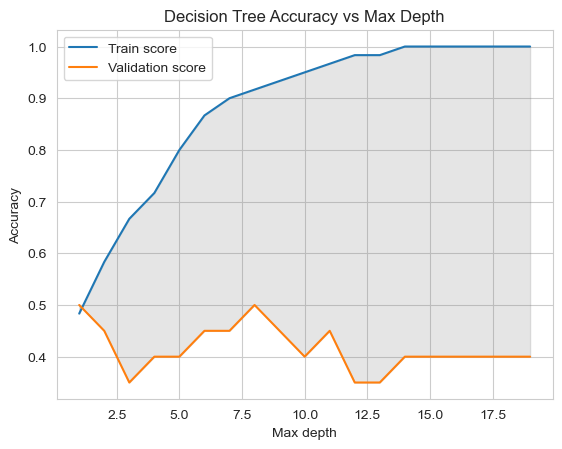

,max_depth,train_acc,val_acc,score_diff
0,1,0.483333,0.50,-0.016667
1,2,0.583333,0.45,0.133333
2,3,0.666667,0.35,0.316667
3,4,0.716667,0.40,0.316667
4,5,0.800000,0.40,0.400000
5,6,0.866667,0.45,0.416667
6,7,0.900000,0.45,0.450000
7,8,0.916667,0.50,0.416667
8,9,0.933333,0.45,0.483333
9,10,0.950000,0.40,0.550000


In [10]:
scores_df = decision_tree(X_bow, X_validate_bow, y_train, y_validate)
scores_df

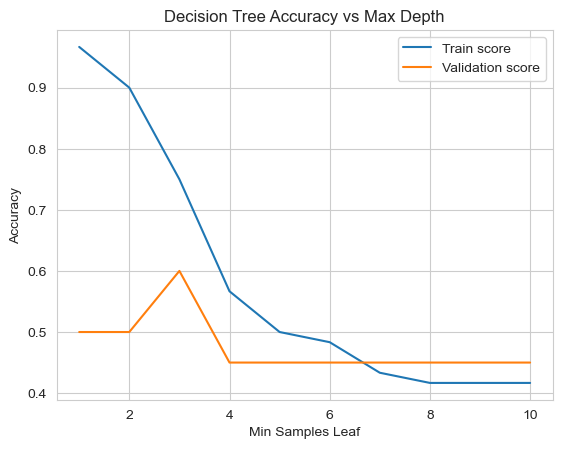

,min_samples_leaf,max_depth,train_score,validate_score,score_difference
0,1,10,0.966667,0.50,0.466667
1,2,9,0.900000,0.50,0.400000
2,3,8,0.750000,0.60,0.150000
3,4,7,0.566667,0.45,0.116667
4,5,6,0.500000,0.45,0.050000
5,6,5,0.483333,0.45,0.033333
6,7,4,0.433333,0.45,-0.016667
7,8,3,0.416667,0.45,-0.033333
8,9,2,0.416667,0.45,-0.033333
9,10,1,0.416667,0.45,-0.033333


In [11]:
df = random_forest_scores(X_bow, y_train, X_validate_bow, y_validate)
df

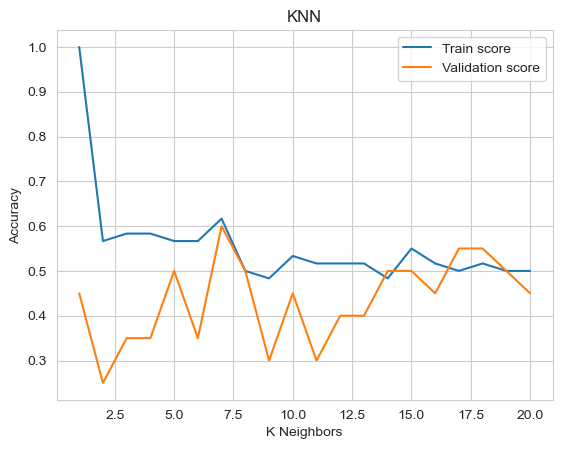

,k,train_score,validate_score,diff_score
0,1,1.000000,0.45,0.550000
1,2,0.566667,0.25,0.316667
2,3,0.583333,0.35,0.233333
3,4,0.583333,0.35,0.233333
4,5,0.566667,0.50,0.066667
5,6,0.566667,0.35,0.216667
6,7,0.616667,0.60,0.016667
7,8,0.500000,0.50,0.000000
8,9,0.483333,0.30,0.183333
9,10,0.533333,0.45,0.083333


In [12]:
df = k_nearest(X_bow, y_train, X_validate_bow, y_validate)
df

In [13]:
best_model_classification_matrix(X_bow, y_train, X_validate_bow, y_validate)

Tree with max depth of 1 train
           HTML  Java  JavaScript      Other    Python  TypeScript  accuracy  \
precision   0.0   0.0         0.0   0.461538  0.625000         0.0  0.483333   
recall      0.0   0.0         0.0   0.960000  0.714286         0.0  0.483333   
f1-score    0.0   0.0         0.0   0.623377  0.666667         0.0  0.483333   
support     4.0   7.0        16.0  25.000000  7.000000         1.0  0.483333   

           macro avg  weighted avg  
precision   0.181090      0.265224  
recall      0.279048      0.483333  
f1-score    0.215007      0.337518  
support    60.000000     60.000000  

Tree with max depth of 1 validate
           HTML  Java  JavaScript     Other    Python  TypeScript  accuracy  \
precision   0.0   0.0         0.0  0.529412  0.333333         0.0       0.5   
recall      0.0   0.0         0.0  1.000000  0.500000         0.0       0.5   
f1-score    0.0   0.0         0.0  0.692308  0.400000         0.0       0.5   
support     1.0   2.0         5.

/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.1

In [14]:
final_test(X_bow, y_train, X_validate_bow, y_validate, X_test_bow, y_test)

Tree with max depth of 1 train
           HTML  Java  JavaScript     Other    Python  TypeScript  accuracy  \
precision   0.0   0.0         0.0  0.437500  0.250000         0.0       0.4   
recall      0.0   0.0         0.0  0.875000  0.333333         0.0       0.4   
f1-score    0.0   0.0         0.0  0.583333  0.285714         0.0       0.4   
support     1.0   2.0         5.0  8.000000  3.000000         1.0       0.4   

           macro avg  weighted avg  
precision   0.114583       0.21250  
recall      0.201389       0.40000  
f1-score    0.144841       0.27619  
support    20.000000      20.00000  
Test accuracy: 0.4


/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
